# Introduction

As we need to scrap a lot of data, we will performe the initial analysis for milestone 2 on a subset of movies and the actors that play in those movies. This is done to show the viability of our approaches. Then as soon as we have the full set of the data, we will scale up our analysis.

## Data Scraping

### Movies Scraping

Due to the large number of movies (around 500k) that we had to get details about by web scraping, after about 8000 requests, IMDB servers started to respond with 503 Service Unavailable status. As a result, we had to use a mechanism that uses the TOR service to renew our IP every one in a while when making the web requests. The following is the code used to do that.

In [1]:
import re
import ast
import time
import requests
import pandas as pd
import numpy as np
import os.path
import urllib.request
import concurrent.futures
from os import listdir
from stem import Signal
from requests import get
from bs4 import BeautifulSoup
from datetime import datetime
from os.path import isfile, join
from stem.control import Controller

def get_tor_session():
    session = requests.session()
    # Tor uses the 9050 port as the default socks port
    session.proxies = {'http':  'socks5://127.0.0.1:9050',
                       'https': 'socks5://127.0.0.1:9050'}
    return session

def renew_connection():
    with Controller.from_port(port = 9051) as controller:
        controller.authenticate(password="password")
        controller.signal(Signal.NEWNYM)
        
if os.path.exists('./pickles/filtered_movies.pkl'):
    movies = pd.read_pickle("./pickles/filtered_movies.pkl")
else:
    title_basics = pd.read_csv("data/title.basics.tsv", sep='\t')
    movies = title_basics[title_basics.titleType == 'movie']
    movies.to_pickle("./filtered_movies.pkl")

def get_data(session, url):
    scraped_data = {
    "tconst": [],
    "stars": [],
    "oscarWins": [],
    "nominations": [],
    "wins": [],
    "releaseDate": [],
    "releaseCountry": [],
    "plotKeywords": [],
    "budget": [],
    "worldwideGross": [],
    "metascore": [],
    "musicProducer": []
    }
    
    info=[]
    
    try:
        r = session.get(url)
        r.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(err)
    page_body = r.text
    soup = BeautifulSoup(page_body, 'html.parser')
    
    #tconst
    tconst=url.rsplit('/', 1)[-1]
    scraped_data['tconst'].append(tconst)
    
    
    with open("./ScrapedPages/tor/{0}.html".format(tconst), "w") as text_file:
        text_file.write(page_body)
        
    # Stars
    stars = []
    stars_h4 = soup.find('h4', string='Stars:')
    if stars_h4 is not None:
        star_atags_parent = stars_h4.parent
        if star_atags_parent is not None:
            star_atags = star_atags_parent.find_all('a')
            if star_atags is not None:
                for atag in star_atags:
                    if atag['href'].startswith('/name/'):
                        stars.append(atag['href'].split('/')[2])
    else:
        stars_h4 = soup.find('h4', string='Star:')
        if stars_h4 is not None:
            star_atags_parent = stars_h4.parent
            if star_atags_parent is not None:
                star_atags = star_atags_parent.find_all('a')
                if star_atags is not None:
                    for atag in star_atags:
                        if atag['href'].startswith('/name/'):
                            stars.append(atag['href'].split('/')[2])
    scraped_data['stars'].append(stars)
    
    
    # Metascore
    metascore = None
    metascore_list = soup.select('.metacriticScore span:first-child')
    if len(metascore_list) > 0:
        metascore = metascore_list[0].string
        
    scraped_data['metascore'].append(metascore if metascore is None else str(metascore))
    
    
    # Awards
    awrds_lines = soup.find_all(class_="awards-blurb")
    oscars = 0
    wins = 0
    nominations = 0
    for line in awrds_lines:
        
        if line.findChild() is not None:
            prepped_str = re.sub(' +', ' ', line.findChild().text.replace("\n", " ").strip())
            res = re.search('(W|w)on (\d+) (O|o)scars.?', prepped_str)
            if res is not None:
                oscars = int(res.group(2))
            
        else:
            prepped_str = re.sub(' +', ' ', line.text.replace("\n", "").strip())
            
            res = re.search('(\d+) wins', prepped_str)
            if res is not None:
                wins = int(res.group(1))
            
            
            res = re.search('(\d+) nominations', prepped_str)
            if res is not None:
                nominations = int(res.group(1))
    scraped_data['oscarWins'].append(oscars)
    scraped_data['wins'].append(wins)
    scraped_data['nominations'].append(nominations)
    
    
    # Release date
    release_date_h4 = soup.find('h4', string='Release Date:')
    release_date = None
    release_country = None
    if release_date_h4 is not None:
        release_date_raw_text = release_date_h4.parent.findAll(text=True, recursive=False)
        release_date_prepped = re.sub(' +', ' ', ''.join(release_date_raw_text).replace("\n", "").strip())
        date_str_match = re.search(r'\d{1,2} \w+ \d{4}', release_date_prepped)
        if date_str_match is not None:
            release_date = datetime.strptime(date_str_match.group(), '%d %B %Y').date()
        release_country_match = re.search(r'\(([a-zA-Z ]{2,})\)', release_date_prepped)
        if release_country_match is not None and len(release_country_match.groups()) > 0:
            release_country = release_country_match.group(1)
        
    scraped_data['releaseDate'].append(release_date)
    scraped_data['releaseCountry'].append(release_country)
    
    
    # Budget
    budget_h4 = soup.find('h4', string='Budget:')
    budget = None
    if budget_h4 is not None:
        budget_raw_text = budget_h4.parent.findAll(text=True, recursive=False)
        budget = re.sub(' +', ' ', ''.join(budget_raw_text).replace("\n", "").strip())
        
    scraped_data['budget'].append(budget)
    
    
    # worldwide gross
    gross_h4 = soup.find('h4', string='Cumulative Worldwide Gross:')
    gross = None
    if gross_h4 is not None:
        gross_h4_text = gross_h4.parent.findAll(text=True, recursive=False)
        gross = re.sub(' +', ' ', ''.join(gross_h4_text).replace("\n", "").strip())
    
    scraped_data['worldwideGross'].append(gross)
    
    
    # Plot keywords
    keywords_verification_threshold = 2 # Consider only words atleast 2 people considered relavent
    keywords_url = url + "/keywords"
    r = get(keywords_url)
    page_body = r.text
    soup = BeautifulSoup(page_body, 'html.parser')
    keywords = []
    plot_keywords_items = soup.find_all(class_="soda sodavote")
    if plot_keywords_items is not None:
        for plot_keywords_item in plot_keywords_items:
            validity_text = plot_keywords_item.find(class_='interesting-count-text').a.text.strip()
            validity_text_match = re.search(r'(\d+) of', validity_text)
            if validity_text_match is not None and len(validity_text_match.groups()) > 0:
                if int(validity_text_match.group(1)) >= keywords_verification_threshold:
                    keywords.append(plot_keywords_item.find(class_='sodatext').a.text.strip())
    
    scraped_data['plotKeywords'].append(keywords)
    
    
    # Music producer
    fullcredits_url = url + "/fullcredits"
    r = get(fullcredits_url)
    page_body = r.text
    soup = BeautifulSoup(page_body, 'html.parser')
    
    music_producer = None
    
    full_credits_container = soup.find(id='fullcredits_content', class_='header')
    if full_credits_container is not None:
        full_credits = full_credits_container.find_all(recursive=False)
        if full_credits is not None:
            for idx, item in enumerate(full_credits, start=0):
                if 'Music by' in item.text:
                    producer_atag = full_credits[idx + 1].find('a')
                    if producer_atag is not None:
                        producer_href = producer_atag['href']
                        if producer_href is not None:
                            music_producer = producer_href.split('/')[2]
                            break
    
    scraped_data['musicProducer'].append(music_producer)
    return scraped_data



# Set the start index and end index. Ip is renewed after each chunk of urls of 'step_size'. 
# After every chunk, result is written to a pickle.
postfix = 'tor'
s_idx = 0
e_idx = 178118 # We scraped information only on 1/3 of the movies due to the time constraints for this submission
step_size = 4000 # Size of one chunk of urls

base_url = 'https://www.imdb.com/title/'
urls=[]
for index, row in movies[s_idx:e_idx].iterrows():
    urls.append(base_url + row['tconst'])

used_ips = []

# Use a thread pool to increase efficiency
with concurrent.futures.ThreadPoolExecutor(max_workers=150) as executor:
    session = get_tor_session()
    chunk_indeces = np.arange(0, len(urls), step_size)
    failed_urls = []
    
    for idx, start in enumerate(chunk_indeces, start=1):
        start_t = time.time()
        finals = {
            "tconst": [],
            "stars": [],
            "oscarWins": [],
            "nominations": [],
            "wins": [],
            "releaseDate": [],
            "releaseCountry": [],
            "plotKeywords": [],
            "budget": [],
            "worldwideGross": [],
            "metascore": [],
            "musicProducer": []
        }
        renew_connection()
        session = get_tor_session()
        new_ip = ast.literal_eval(session.get("http://httpbin.org/ip").text)["origin"].split(",")[0]
        while new_ip in used_ips:
            print("Renewed IP {0} already used. Waiting 5s to renew...".format(new_ip))
            time.sleep(5)
            renew_connection()
            session = get_tor_session()
            new_ip = ast.literal_eval(session.get("http://httpbin.org/ip").text)["origin"].split(",")[0]
        used_ips.append(new_ip)
        
        url_chunk = urls[start:start + step_size] + failed_urls
        failed_urls = []
        
        future_to_url = {executor.submit(get_data, session, url): url for url in url_chunk}
        for future in concurrent.futures.as_completed(future_to_url):
            url = future_to_url[future]
            try:
                data = future.result()
                for k, v in data.items():
                    finals[k].append(v[0])
            except Exception as exc:
                failed_urls.append(url.strip("'"))
                print('%s generated an exception: %s. Added to retry list.' % (url, exc))
        
        concurrent.futures.wait(list(future_to_url.keys()), timeout=None, return_when=concurrent.futures.ALL_COMPLETED)
        end_t = time.time()
        print("chunk {0} of {1} completed with IP {2}. Took {3} seconds.".format(idx, len(chunk_indeces), new_ip, end_t - start_t))   
        movies_df = pd.DataFrame(data=finals)
        pickle_path = "./pickles/tor/{0}_{1}-{2}_{3}.pkl".format(idx, start, start + step_size, postfix)
        movies_df.to_pickle(pickle_path)
        print("Wrote pickle {0} with {1} rows".format(pickle_path, len(movies_df)))
        

# Combine the created pickles into one Dataframe
dir_path = "./pickles/tor"
# Ignore any sytem files starting with . or folders if any
pickles = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) and not f.startswith('.')]
dfs = list(map(lambda x: pd.read_pickle("{0}/{1}".format(dir_path,x)), pickles))
combined_df = pd.concat(dfs)
combined_df.reset_index(drop=True, inplace=True)
combined_df.to_pickle("./pickles/complete_{0}.pkl".format(e_idx))
print(len(combined_df))

KeyboardInterrupt: 

### Actor Awards Scraping

The awards and nominations of the actors ware also scraped using the same mechanism used for scraping the movies. Follwoing is the code used for that.

In [ ]:
import re
import ast
import time
import requests
import pandas as pd
import numpy as np
import os.path
import urllib.request
import concurrent.futures
from os import listdir
from stem import Signal
from requests import get
from bs4 import BeautifulSoup
from datetime import datetime
from os.path import isfile, join
from stem.control import Controller

movie_subset = pd.read_pickle("./pickles/complete_178118.pkl")

# Due to time constraints
stars_exploded = movie_subset.explode('stars')[['tconst', 'stars']]
stars_counts = stars_exploded\
                    .groupby('stars')\
                    .count()\
                    .rename(columns={"tconst": "count"})\
                    .sort_values(['count'], ascending=False)
stars_counts.index.name = 'nconst'
stars_subset = stars_counts[stars_counts['count'] > 1]

def get_tor_session():
    session = requests.session()
    # Tor uses the 9050 port as the default socks port
    session.proxies = {'http':  'socks5://127.0.0.1:9050',
                       'https': 'socks5://127.0.0.1:9050'}
    return session

def renew_connection():
    with Controller.from_port(port = 9051) as controller:
        controller.authenticate(password="password")
        controller.signal(Signal.NEWNYM)

def get_data(session, url):
    nconst=url.rsplit('/', 2)[-2]
    result = []
    
    
    with session.get(url) as req:
        req.raise_for_status()    
    
        body=req.text

        soup=BeautifulSoup(body,'html.parser')
        awards=soup.find_all('tr')
        if awards is not None:
            year_buf = []
            w_n_buf = []
            category_buf = []
            for award in awards:
                award_record = {
                    'nconst': nconst,
                    'year': None,
                    'category': None,
                    'w_n': None,
                    'description': None,
                    'movie': None,
                    'tconst': None
                } 
                if award.find('td', class_='award_year') is not None:
                    award_year_td = award.find('td', class_='award_year')
                    if award_year_td.find('a') is not None:
                        
                        year = award.find('td', class_='award_year').find('a').text
                        if year is not None:
                            try:
                                year = int(year.replace("\n", "").strip())
                                award_record['year'] = year
                                
                                # If the td has a row span more than 1, cache the value so it will be used 
                                # with the subsequent corresponding trs as well
                                if award_year_td['rowspan'] is not None:
                                    award_year_td_rs = int(award_year_td['rowspan'])
                                    for i in range(0, award_year_td_rs - 1):
                                        year_buf.append(year)
                            except:
                                print("Failed to parse int year {0}".format(year))

                elif len(year_buf) > 0:
                    buffed_year = year_buf.pop()
                    award_record['year'] = buffed_year

                if award.find('td',class_='award_outcome') is not None:
                    award_outcome_td = award.find('td',class_='award_outcome')
                    if award_outcome_td.find('span',class_='award_category') is not None:
                        award_cat = award_outcome_td.find('span',class_='award_category').text
                        award_record['category'] = award_cat
                        
                    if award_outcome_td.find('b') is not None:
                        w_n_txt = award_outcome_td.find('b').text
                        if w_n_txt is not None:
                            w_n = w_n_txt.replace("\n", "").strip()
                            award_record['w_n'] = w_n
                            
                    if award_outcome_td['rowspan'] is not None:
                        award_outcome_td_rs = int(award_outcome_td['rowspan'])
                        for i in range(0, award_outcome_td_rs - 1):
                            category_buf.append(award_cat)
                            w_n_buf.append(w_n)
                else:
                    if len(w_n_buf) > 0:
                        buffed_w_n = w_n_buf.pop()
                        award_record['w_n'] = buffed_w_n
                    if len(category_buf) > 0:
                        buffed_category = category_buf.pop()
                        award_record['category'] = buffed_category
                    

                if award.find('td', class_='award_description') is not None:
                    award_txt = award.find('td',class_='award_description').find(text=True, recursive=False)
                    award_info = award.find('td',class_='award_description').find('a', href=re.compile(r'.*tt\d{7}.*'))
                    if award_txt is not None:
                        award_record['description'] = award_txt.replace("\n", "").strip()

                    if award_info is not None:
                        tconst_res = re.search('tt\d{7}', award_info.get('href'))
                        if tconst_res is not None:
                            award_record['tconst'] = tconst_res.group(0)
                            award_record['movie'] = award_info.text
                result.append(award_record)

            return result

        
# Set the start index and end index. Ip is renewed after each chunk of urls of 'step_size'. 
# After every chunk, result is written to a pickle. 
postfix = 'actors_subset'
s_idx = 0
e_idx = len(stars_subset)
step_size = 2000 # Size of one chunk of urls
pickles_save_dir = './pickles/{0}/2of3moviessubset'.format(postfix)

base_url = 'https://www.imdb.com/name/{0}/awards'
urls=[]
for nconst in stars_subset.index[s_idx:e_idx]:
    urls.append(base_url.format(nconst))

used_ips = []
failed_urls = []


session = get_tor_session()
chunk_indeces = np.arange(0, len(urls), step_size)

# use a threadpool to speed up the scraping
for idx, start in enumerate(chunk_indeces, start=1):
    with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
        start_t = time.time()
        finals = []
        renew_connection()

        session = get_tor_session()
        new_ip = ast.literal_eval(session.get("http://httpbin.org/ip").text)["origin"].split(",")[0]
        while new_ip in used_ips:
            print("Renewed IP {0} already used. Waiting 5s to renew...".format(new_ip))
            time.sleep(5)
            renew_connection()
            session = get_tor_session()
            new_ip = ast.literal_eval(session.get("http://httpbin.org/ip").text)["origin"].split(",")[0]
        used_ips.append(new_ip)

        url_chunk = urls[start:start + step_size] + failed_urls
        failed_urls = []

        future_to_url = {executor.submit(get_data, session, url): url for url in url_chunk}
        for future in concurrent.futures.as_completed(future_to_url):
            url = future_to_url[future]
            try:
                data = future.result()
                finals += data
            except Exception as exc:
                failed_urls.append(url.strip("'"))
                print('%s generated an exception: %s. Added to retry list.' % (url, exc))

        concurrent.futures.wait(
            list(future_to_url.keys()), 
            timeout=None, 
            return_when=concurrent.futures.ALL_COMPLETED)
        end_t = time.time()
        print("chunk {0} of {1} completed with IP {2}. Took {3} seconds."\
              .format(idx, len(chunk_indeces), new_ip, end_t - start_t))   
        actors_df = pd.DataFrame(data=finals)
        if not os.path.exists(pickles_save_dir):
            os.makedirs(pickles_save_dir)
        pickle_path = "{4}/{0}_{1}-{2}_{3}.pkl"\
                        .format(idx, start, start + step_size, postfix, pickles_save_dir)
        actors_df.to_pickle(pickle_path)
        print("Wrote pickle {0} with {1} rows".format(pickle_path, len(actors_df)))

if len(failed_urls) > 0:
    print('\n\n\n\n!!!**********************************!!!')
    print('Failed to retrieve the following URLs.\n')
    print(failed_urls)
    print('\n!!!**********************************!!!')
    print('Note: Run the following cell to retry the failed urls')
else:
    print("\n\n\n\n!!!**********************************!!!\n")
    print("Scraping succeeded!")
    print('\n!!!**********************************!!!')
    print('''Note: Next, run the script that combine all pickles''')
    
    
# Combine the created pickles into one Dataframe
# Ignore any sytem files starting with . or folders if any
pickles = [f for f in listdir(pickles_save_dir) if isfile(join(pickles_save_dir, f)) and not f.startswith('.')]

dfs = list(map(lambda x: pd.read_pickle("{0}/{1}".format(pickles_save_dir,x)), pickles))
combined_df = pd.concat(dfs)
combined_df.reset_index(drop=True, inplace=True)
if not os.path.exists('./pickles'):
    os.makedirs('./pickles')
combined_df.to_pickle("./pickles/complete_{1}_{0}.pkl".format(e_idx, postfix))

# Raw Data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

In [6]:
df_movies_subset=pd.read_pickle('./pickles/movies_subset.pkl')
df_actors_awards=pd.read_pickle('./pickles/actors_awards_subset.pkl')
df_movies=pd.read_csv('data/title.basics.tsv', sep='\t',na_values= '\\N')
df_actors=pd.read_csv('data/name.basics.tsv.gz', sep='\t')
df_ratings=pd.read_csv('data/title.ratings.tsv', sep='\t')

/home/laurent/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We start by merging the different data sets with information about the movies into one data set.

### Movies data

In [7]:
#adding our scrapped data to the original movie data set
movies_data=df_movies_subset.merge(df_movies,how='inner', on='tconst')
movies_data=movies_data.merge(df_ratings, how='left', on='tconst').drop(['titleType','isAdult','endYear'],axis=1)

In [8]:
with pd.option_context('display.max_columns', 50):
    display(movies_data.head())

tconst                              stars  oscarWins  nominations  wins  \
0  tt0014799  [nm0265550, nm0370407, nm0550195]          0            0     0   
1  tt0014843  [nm0427659, nm0107574, nm0421138]          0            0     0   
2  tt0014809  [nm0267916, nm0119572, nm0055809]          0            0     0   
3  tt0014751             [nm0403710, nm0744408]          0            0     0   
4  tt0014812  [nm0556953, nm0531962, nm0645941]          0            0     0   

  releaseDate releaseCountry plotKeywords budget worldwideGross metascore  \
0  1924-05-31             UK           []   None           None      None   
1  1924-08-24            USA           []   None           None      None   
2  1924-04-08            USA           []   None           None      None   
3        None           None           []   None           None      None   
4  1924-12-28            USA           []   None           None      None   

  musicProducer                primaryTitle               originalTitle  \
0          None            The Conspirators            The Conspirators   
1          None           The Desert Outlaw           The Desert Outlaw   
2          None              Crossed Trails              Crossed Trails   
3          None  La buenaventura de Pitusín  La buenaventura de Pitusín   
4          None                    Curlytop                    Curlytop   

   startYear runtimeMinutes         genres  averageRating  numVotes  
0     1924.0            NaN    Crime,Drama            NaN       NaN  
1     1924.0             60        Western            NaN       NaN  
2     1924.0             50        Western            NaN       NaN  
3     1924.0            NaN            NaN            NaN       NaN  
4     1924.0             60  Drama,Romance            NaN       NaN

#### Description of the data

- tconst: Unique imdb identifier of each movie, given as string
- stars: Three main actors playing in the movie , given as list of strings, scraped 
- oscarWins: Number of Oscars awarded to the movie, given as float, scraped 
- nominations: Number of general award nominations, given as float, scraped
- wins: Number of awards won, given as integer, scraped
- releaseDate: Date release of the movie, given as DateTime, scraped
- releaseCountry: Country of release, given as string, scraped
- plotKeywords: Keywords describing the plot of the movie, given as list of strings, scraped
- budget: production budget of the movie, given as string, scraped
- worldwideGross: Wordlwide revenue, given as string, scrapped
- metascore: Scores are assigned to movie's reviews of large group of the world's most respected critics, and weighted average are applied to summarize their opinions range, given as float, scraped
- musicProducer: Producer of the music in the movie, string, scraped
- primaryTitle: English title, string
- originalTitle: Original title, string
- startYear: Year of release, integer
- runtimeMinutes: Runtime of the movie in minutes, string, scraped
- genres: genres the movie can be attributed to, string
- averageRating: Average rating of the movie given by imbd users, float
- numVotes: Number of users that have scored the movie, float



### Actors data

In [9]:
df_actors_awards.head()

nconst  year       category      w_n  \
0  nm0309470  2005          David  Nominee   
1  nm0309470  1968   Golden Plate   Winner   
2  nm0309470  2005    Golden Ciak   Winner   
3  nm0309470  1967   Golden Globe   Winner   
4  nm0309470  1968  Golden Goblet   Winner   

                                         description               movie  \
0  Best Supporting Actress (Migliore Attrice non ...         Cuore sacro   
1                                                             Grazie zia   
2  Best Supporting Actress (Migliore Attrice Non ...         Cuore sacro   
3                    Best Actress (Migliore Attrice)  Svegliati e uccidi   
4                    Best Actress (Migliore Attrice)          Grazie zia   

      tconst  
0  tt0429898  
1  tt0063033  
2  tt0429898  
3  tt0061049  
4  tt0063033

#### Description of the data

* nconst: Unique IMDB IDs of actors
* year: Year of award or nominaion
* category : Award ceramony
* w_n : Winner or Nominee
* description: Description of the award
* movie: Name of the movie in which the actor played on
* tconst: Unique IMDB Id of movie in which the actor played on

In [10]:
df_actors.head()

nconst      primaryName birthYear deathYear  \
0  nm0000001     Fred Astaire      1899      1987   
1  nm0000002    Lauren Bacall      1924      2014   
2  nm0000003  Brigitte Bardot      1934        \N   
3  nm0000004     John Belushi      1949      1982   
4  nm0000005   Ingmar Bergman      1918      2007   

                primaryProfession                           knownForTitles  
0  soundtrack,actor,miscellaneous  tt0050419,tt0043044,tt0072308,tt0053137  
1              actress,soundtrack  tt0038355,tt0037382,tt0117057,tt0071877  
2     actress,soundtrack,producer  tt0054452,tt0059956,tt0049189,tt0057345  
3         actor,writer,soundtrack  tt0080455,tt0078723,tt0077975,tt0072562  
4           writer,director,actor  tt0050976,tt0050986,tt0083922,tt0069467

#### Description of the data

* nconst : IMDB Id of the person  
* primaryName : Last name and first name  
* birthYear : For computing the age of actors/actresses
* primaryProfession : list of professions

In [11]:
df_ratings.head()

tconst  averageRating  numVotes
0  tt0000001            5.6      1551
1  tt0000002            6.1       186
2  tt0000003            6.5      1209
3  tt0000004            6.2       113
4  tt0000005            6.1      1935

#### Description of the data

* tconst : Id of the movie  
* averageRating : Weighted average of all the individual user ratings  
* numVotes : Number of votes the title has received (Can be used as an indicator of movie popularity)  

## Data Wrangling

### Movie Data

In movies_data we need to change a few columns to achive our goal:

- releaseDate, here we only want the month, to see if there is seasonality, the release year is given seperately
- for budget and wordwideGross: These are given in different currency depending on the movie. Furthermore, they are not always given in the same currency for a given movie. To proceed we first need to convert the strings into integers and then we would need to convert all the numbers into dollars to make them comparable.
- runtime: Transforme to integers
- genres: Transforme to list of strings

Furthermore, there are some columns we are not interested in, that we can drop.

In [12]:
#extracting month
movies_data['releaseMonth']=movies_data['releaseDate'].map(lambda x:  x.month if x is not None else None)

We will extract the release year from the release date and we will drop the startyear feature.

In [13]:
#extracting year
movies_data['releaseYear']=movies_data['releaseDate'].map(lambda x:  int(x.year) if x is not None else None)

In [17]:
#first we need to change worldwideGross and budget to integers
import re
    
def to_int(x):
    if x ==None:
        val=None
        dollar= False
    else:
        val= int(re.sub('[^0-9,]', "", x).replace(",", ""))
        if x.startswith('$'):
            dollar= True
        else:
            dollar= False
    return val, dollar
    
movies_data['budget'],movies_data['budget_in_dollar'] = zip(*movies_data['budget'].apply(to_int))
movies_data['worldwideGross'], movies_data['worldwideGross_in_dollar']= zip(*movies_data['worldwideGross']\
                                                                            .apply(to_int))
#now we can calculate the revenue percentage
movies_data['revenue']=movies_data['worldwideGross']/movies_data['budget']-1

TypeError: expected string or bytes-like object

In [19]:
#only extracting one genre
#Needs to be improved as genres are just orderd in alphabetical order not importance
movies_data.genres=movies_data.genres.str.split(',')

In [20]:
with pd.option_context('display.max_columns', 50):
    display(movies_data.head())

tconst                              stars  oscarWins  nominations  wins  \
0  tt0014799  [nm0265550, nm0370407, nm0550195]          0            0     0   
1  tt0014843  [nm0427659, nm0107574, nm0421138]          0            0     0   
2  tt0014809  [nm0267916, nm0119572, nm0055809]          0            0     0   
3  tt0014751             [nm0403710, nm0744408]          0            0     0   
4  tt0014812  [nm0556953, nm0531962, nm0645941]          0            0     0   

  releaseDate releaseCountry plotKeywords budget worldwideGross metascore  \
0  1924-05-31             UK           []   None           None      None   
1  1924-08-24            USA           []   None           None      None   
2  1924-04-08            USA           []   None           None      None   
3        None           None           []   None           None      None   
4  1924-12-28            USA           []   None           None      None   

  musicProducer                primaryTitle               originalTitle  \
0          None            The Conspirators            The Conspirators   
1          None           The Desert Outlaw           The Desert Outlaw   
2          None              Crossed Trails              Crossed Trails   
3          None  La buenaventura de Pitusín  La buenaventura de Pitusín   
4          None                    Curlytop                    Curlytop   

   startYear runtimeMinutes            genres  averageRating  numVotes  \
0     1924.0            NaN    [Crime, Drama]            NaN       NaN   
1     1924.0             60         [Western]            NaN       NaN   
2     1924.0             50         [Western]            NaN       NaN   
3     1924.0            NaN               NaN            NaN       NaN   
4     1924.0             60  [Drama, Romance]            NaN       NaN   

   releaseMonth  releaseYear  budget_in_dollar  worldwideGross_in_dollar  
0           5.0       1924.0             False                     False  
1           8.0       1924.0             False                     False  
2           4.0       1924.0             False                     False  
3           NaN          NaN             False                     False  
4          12.0       1924.0             False                     False

In [21]:
movies_data.isnull().any()

tconst                      False
stars                       False
oscarWins                   False
nominations                 False
wins                        False
releaseDate                  True
releaseCountry               True
plotKeywords                False
budget                       True
worldwideGross               True
metascore                    True
musicProducer                True
primaryTitle                False
originalTitle                True
startYear                    True
runtimeMinutes               True
genres                       True
averageRating                True
numVotes                     True
releaseMonth                 True
releaseYear                  True
budget_in_dollar            False
worldwideGross_in_dollar    False
dtype: bool

We can see that there a lot of missing values denoted by None. One major cause behind these missing data is due to the lack of information regarding the old (from around 1890 to 1930) movies. We will ignore these values when doing computations on them.

### Actors Data

Out of the awards data of the actors we want to build a score for the actors. We will score the wins and nominations in the top 10 movies awards according to https://www.therichest.com/most-popular/top-10-most-prestigious-movie-awards-in-the-world/ higher then the wins and nominations in the other awards.

In [22]:
best_award=['Golden Globe','Oscar', 'Golden Lion','Grand Jury Prize','Golden Leopard','European Film Award', 'Filmfare Award','Golden Berlin Bear','BAFTA Film Award',"Palme d'Or"]

In [23]:
df_actors_awards['Important']=[False]*df_actors_awards.shape[0]

In [24]:
df_actors_awards['Important'][df_actors_awards.category.isin(best_award)]=True

/home/laurent/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
df_actors_awards.head()

nconst  year       category      w_n  \
0  nm0309470  2005          David  Nominee   
1  nm0309470  1968   Golden Plate   Winner   
2  nm0309470  2005    Golden Ciak   Winner   
3  nm0309470  1967   Golden Globe   Winner   
4  nm0309470  1968  Golden Goblet   Winner   

                                         description               movie  \
0  Best Supporting Actress (Migliore Attrice non ...         Cuore sacro   
1                                                             Grazie zia   
2  Best Supporting Actress (Migliore Attrice Non ...         Cuore sacro   
3                    Best Actress (Migliore Attrice)  Svegliati e uccidi   
4                    Best Actress (Migliore Attrice)          Grazie zia   

      tconst  Important  
0  tt0429898      False  
1  tt0063033      False  
2  tt0429898      False  
3  tt0061049       True  
4  tt0063033      False

In the actors data set we want to have the gender as an aditional feature

In [26]:
#splitting professions
df_actors.primaryProfession=df_actors.primaryProfession.str.split(',')

In [27]:
def m_f(x):
    if type(x) is list:
        if 'actor' in x:
            return 'M'
        elif 'actress' in x:
            return 'F'
        else:
            return None
    else:
        return None

In [28]:
df_actors['gender']=df_actors.primaryProfession.apply(m_f)

In [29]:
df_actors.head()

nconst      primaryName birthYear deathYear  \
0  nm0000001     Fred Astaire      1899      1987   
1  nm0000002    Lauren Bacall      1924      2014   
2  nm0000003  Brigitte Bardot      1934        \N   
3  nm0000004     John Belushi      1949      1982   
4  nm0000005   Ingmar Bergman      1918      2007   

                    primaryProfession  \
0  [soundtrack, actor, miscellaneous]   
1               [actress, soundtrack]   
2     [actress, soundtrack, producer]   
3         [actor, writer, soundtrack]   
4           [writer, director, actor]   

                            knownForTitles gender  
0  tt0050419,tt0043044,tt0072308,tt0053137      M  
1  tt0038355,tt0037382,tt0117057,tt0071877      F  
2  tt0054452,tt0059956,tt0049189,tt0057345      F  
3  tt0080455,tt0078723,tt0077975,tt0072562      M  
4  tt0050976,tt0050986,tt0083922,tt0069467      M

## Data exploration

Now that we have the data sets cleaned we can do the initial data analysis.

#### Movies data

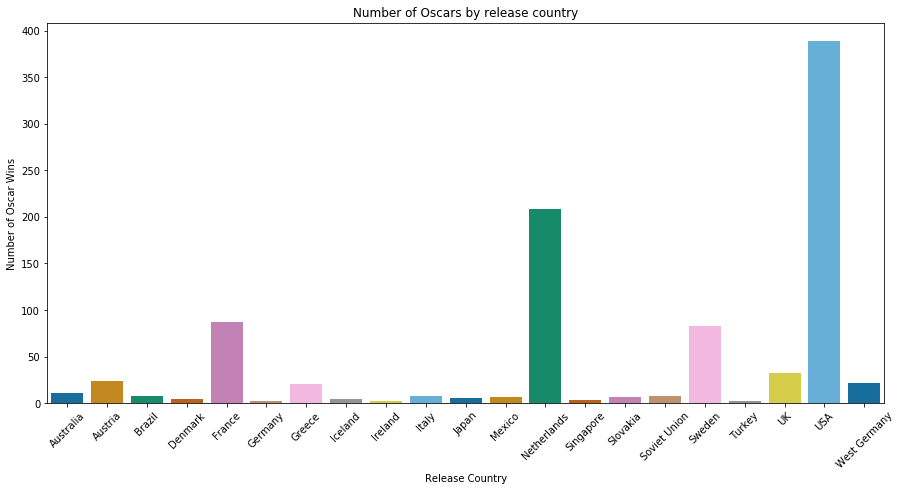

In [30]:
plt.figure(figsize=(15,7))
chart=sns.barplot(x='releaseCountry',y='oscarWins',data=pd.DataFrame(movies_data[movies_data['oscarWins']>0].groupby('releaseCountry')['oscarWins'].sum().reset_index()),palette='colorblind')
chart.set_xticklabels(chart.get_xticklabels(),rotation=45)
plt.title('Number of Oscars by release country')
plt.xlabel('Release Country')
plt.ylabel('Number of Oscar Wins')
plt.show()

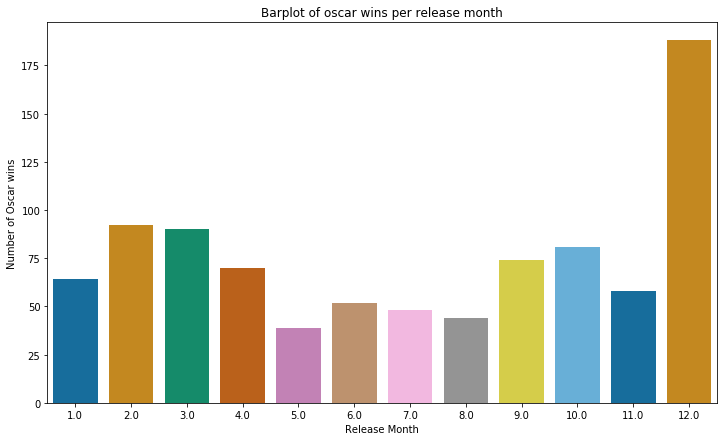

In [31]:
plt.figure(figsize=(12,7))
sns.barplot('releaseMonth', 'oscarWins', data=movies_data.groupby('releaseMonth')['oscarWins'].sum().reset_index(),palette='colorblind')
plt.ylabel('Number of Oscar wins')
plt.xlabel('Release Month')
plt.title('Barplot of oscar wins per release month')
plt.show()

In [32]:
year_month=movies_data.groupby(['releaseMonth','releaseYear']).sum()

In [33]:
Year_month_oscar=year_month.pivot_table(index='releaseMonth',columns='releaseYear',values='oscarWins').fillna(0)

In [34]:
Year_month_oscar.head()

releaseYear   1894.0  1898.0  1899.0  1900.0  1901.0  1903.0  1904.0  1905.0  \
releaseMonth                                                                   
1.0              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2.0              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3.0              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4.0              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5.0              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

releaseYear   1906.0  1907.0  ...  2019.0  2020.0  2021.0  2022.0  2023.0  \
releaseMonth                  ...                                           
1.0              0.0     0.0  ...     3.0     0.0     0.0     0.0     0.0   
2.0              0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
3.0              0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
4.0              0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
5.0              0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   

releaseYear   2024.0  2025.0  2026.0  2027.0  2115.0  
releaseMonth                                          
1.0              0.0     0.0     0.0     0.0     0.0  
2.0              0.0     0.0     0.0     0.0     0.0  
3.0              0.0     0.0     0.0     0.0     0.0  
4.0              0.0     0.0     0.0     0.0     0.0  
5.0              0.0     0.0     0.0     0.0     0.0  

[5 rows x 131 columns]

In [35]:
oscars_heat=Year_month_oscar.iloc[1:,35:]

Text(0.5, 1, 'Number of oscar wining movies subject to the release date')

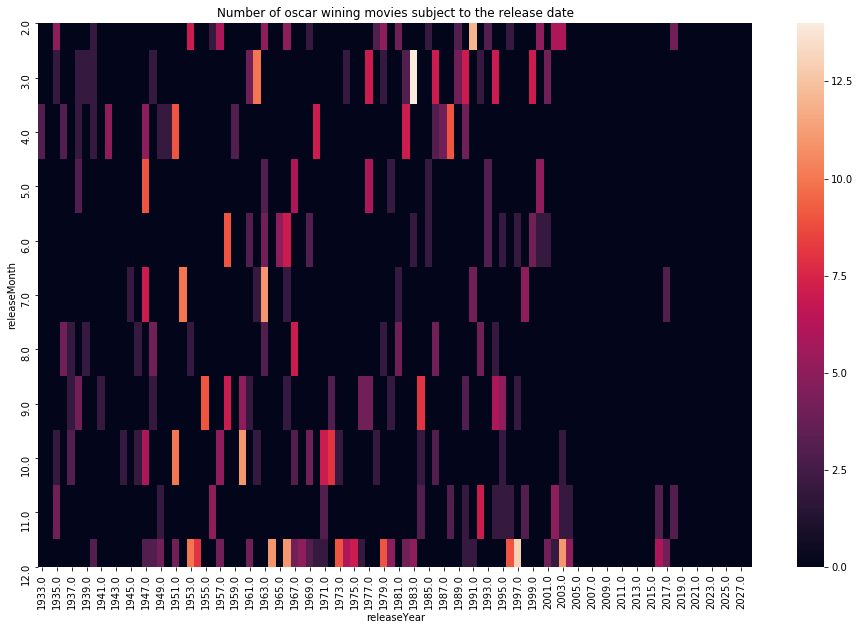

In [36]:
fig, ax = plt.subplots(figsize=(16,10)) 
sns.heatmap(oscars_heat,ax=ax)
plt.title('Number of oscar wining movies subject to the release date')

In [37]:
movies_data.metascore.describe()

count     8348
unique     100
top         68
freq       213
Name: metascore, dtype: object

In [38]:
def transform(meta):
    if meta is not None:
        return int(meta)
    else:
        return None
    

In [39]:
movies_data['metascore']=movies_data.apply(lambda x: transform(x.metascore),axis=1)

In [40]:
movies_data.metascore.describe()

count    8348.000000
mean       59.101581
std        17.917205
min         1.000000
25%        47.000000
50%        61.000000
75%        72.000000
max       100.000000
Name: metascore, dtype: float64

Text(0.5, 1.0, 'histogram of the metascore')

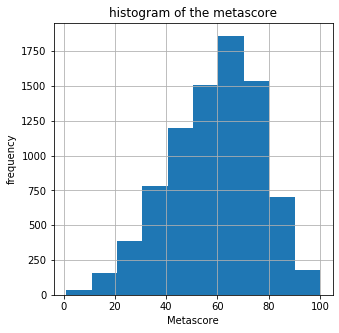

In [41]:
ax, fig= plt.subplots(figsize=(5,5))
movies_data.metascore.hist()
plt.xlabel('Metascore')
plt.ylabel('frequency')
plt.title('histogram of the metascore')

Text(0.5, 1.0, 'Scatter plot of the number of wins vs metascore')

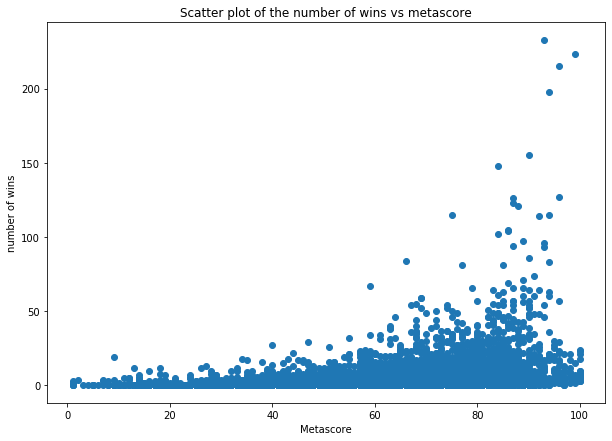

In [42]:
ax,fig=plt.subplots(figsize=(10,7))
plt.scatter(movies_data.metascore,movies_data.wins)
plt.xlabel('Metascore')
plt.ylabel('number of wins')
plt.title('Scatter plot of the number of wins vs metascore')

In [43]:
#Correlation:
cor=movies_data.corr()

Text(0.5, 1, 'The correlation matrix of the movies dataset')

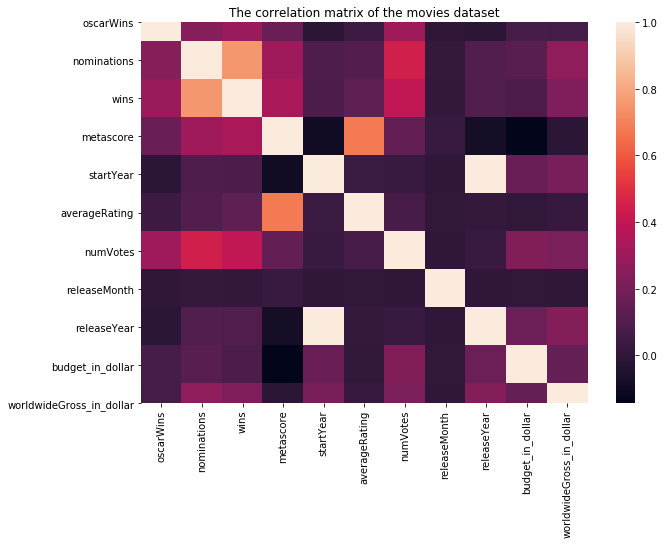

In [44]:
ax, fig= plt.subplots(figsize=(10,7))
sns.heatmap(cor)
plt.title('The correlation matrix of the movies dataset')

We will inspect the evolution of movie's genre.
We will use the IMDB dataset df_movies imported in the begining.

In [45]:
movies=pd.DataFrame(df_movies)
#Extracting the movies
movies=movies[(movies.titleType=='movie')]

As you can see, IMDB assigns a list of genres for each movie ordered alphabetically. So a single movie will be counted more than once when we will count the number of movies in each genre class.

In [46]:
#The genre feature is a list of strings, so we will split it and explode the data set subject to genres:
movies.genres= movies.apply(lambda x: str(x['genres']).split(',') , axis=1)
movies=movies.explode('genres')

In [47]:
#Taking the features that we need to inspect the evolution.
movies_sh= movies[['tconst','startYear','genres']]

In [48]:
movies_sh=movies_sh.rename({'startYear':'year'},axis=1)

In [49]:
#Removing the None genre
movies_sh=movies_sh[movies_sh.genres!=None]

In [50]:
#We will group by the data subject to year and genres and we will get the number of movies corresponding to each year and genre
#by applying the size function
#reset_index will remove the hierarchical indexing so that we get in each raw the year and the genres
year_genre=pd.DataFrame(movies_sh.groupby(['year','genres']).size())
year_genre=year_genre.reset_index()
year_genre=year_genre.rename({0:'nbr'},axis=1)
year_genre.head(5)

year       genres  nbr
0  1894.0      Romance    1
1  1897.0  Documentary    2
2  1897.0         News    2
3  1897.0        Sport    2
4  1898.0  Documentary    8

Now we will prepare the framework to plot the animated evolution of the genre through the years.
We used ticker and animation from the Matplotlib library and HTML from IPYTHON.display to construct our animation.

In [51]:
current_year=2000
df=year_genre[pd.to_numeric(year_genre.year)==current_year].sort_values(by='nbr',ascending=True)
colors = dict(zip(df.year.unique(), ['#adb0ff', '#ffb3ff', '#90d595', '#e48381','aafbff', '#f7bb5f', '#eafb50']))
group_lk = df['genres'].to_dict()

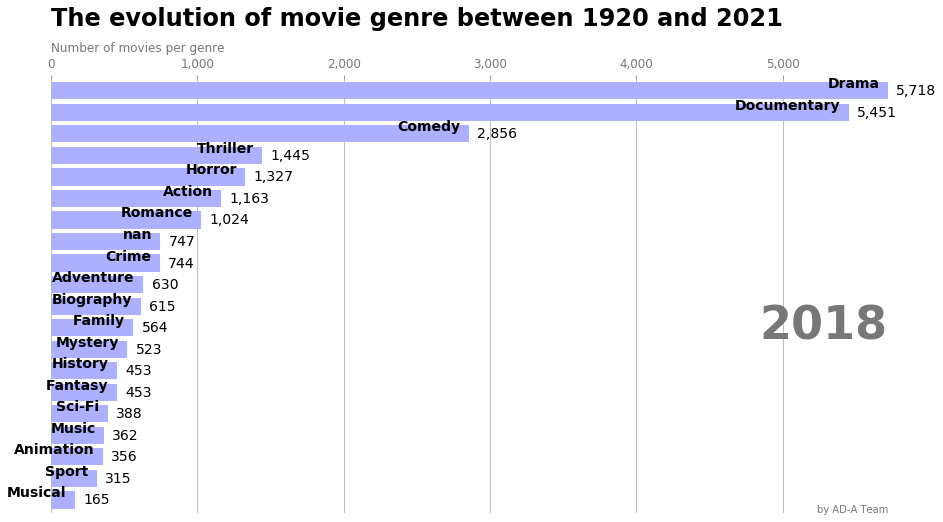

In [52]:
fig, ax = plt.subplots(figsize=(15, 8))
#the function draw_barchart will returns the barplot of the movies genre distribution for a given year.
def draw_barchart(year):

    df = year_genre[year_genre['year'].eq(year)].sort_values(by='nbr', ascending=True).tail(20)

    ax.clear()

    ax.barh(df['genres'], df['nbr'],color='#adb0ff')

    dx = df['nbr'].max()/100

    for i, (nbr, genre) in enumerate(zip(df['nbr'], df['genres'])):

        ax.text(nbr-dx, i,     genre,           size=14, weight=600, ha='right', va='bottom')
        ax.text(nbr+dx, i,     f'{nbr:,.0f}',  size=14, ha='left',  va='center')

    # ... polished styles

    ax.text(1, 0.4, year, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)

    ax.text(0, 1.06, 'Number of movies per genre', transform=ax.transAxes, size=12, color='#777777')

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    ax.xaxis.set_ticks_position('top')

    ax.tick_params(axis='x', colors='#777777', labelsize=12)

    ax.set_yticks([])

    ax.margins(0, 0.01)

    ax.grid(which='major', axis='x', linestyle='-')

    ax.set_axisbelow(True)

    ax.text(0, 1.12, 'The evolution of movie genre between 1920 and 2021',

            transform=ax.transAxes, size=24, weight=600, ha='left')
    
    ax.text(1, 0, 'by AD-A Team', transform=ax.transAxes, ha='right',

            color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

    plt.box(False)

    

draw_barchart(2018)

In case the following animation does not work, please use this link: https://nbviewer.jupyter.org/github/Ruchiranga/AD_A-team-project/blob/master/Milestone2.ipynb

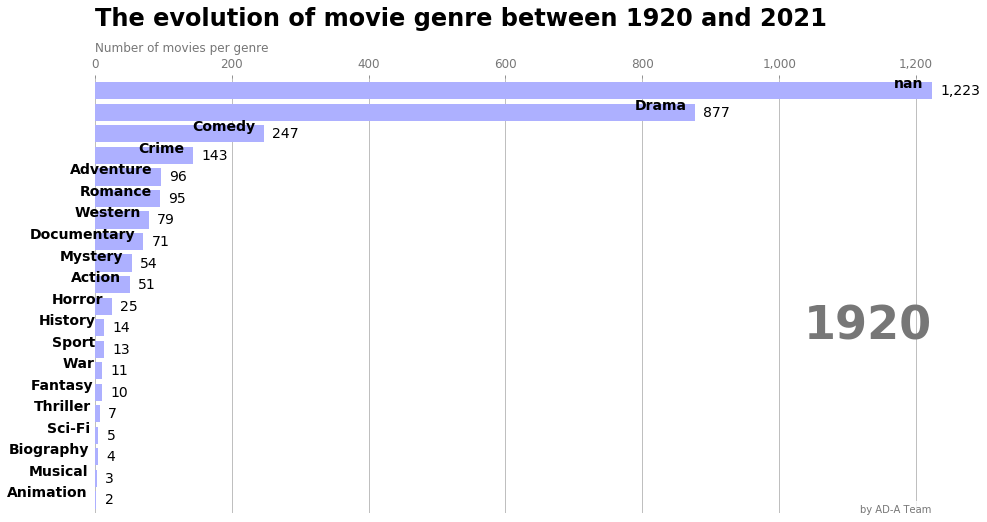

In [53]:
#The animated barplot will be constructed via FuncAnimation 
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(1920, 2019))
HTML(animator.to_jshtml()) 

### Which Actors are in Oscar winning movies and which award did they win

In [55]:
df_oscar_movies=movies_data[movies_data.oscarWins>0]

In [72]:
oscar_stars=df_oscar_movies.stars.apply(pd.Series).stack().reset_index(drop=True)

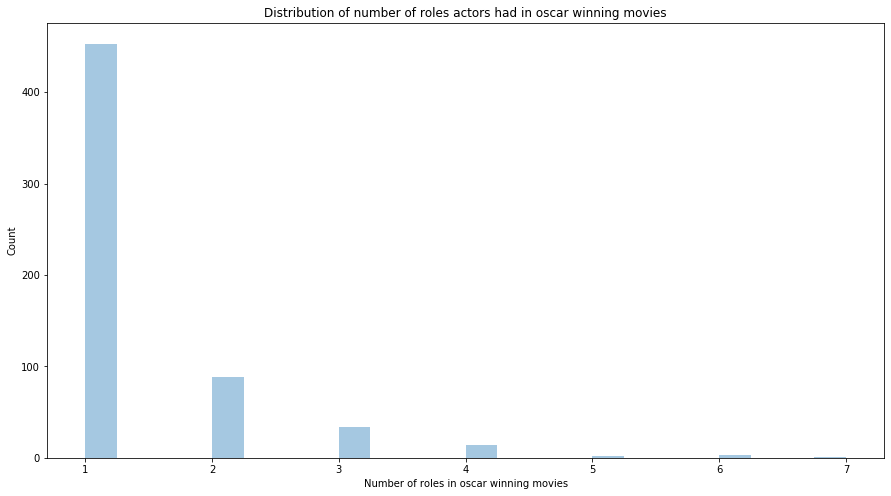

In [83]:
plt.figure(figsize=(15,8))
sns.distplot(oscar_stars.value_counts(),kde=None)
plt.xlabel('Number of roles in oscar winning movies')
plt.ylabel('Count')
plt.title('Distribution of number of roles actors had in oscar winning movies')
plt.show()

We can see, that most actors, who had a leading role in an oscar winning movie, had only a leading role in that movie. But there are some actors who played in up to seven oscar winning movies. We can now investigate a little bit further, for example what prizes did these actors win.

In [90]:
df_oscar_stars=oscar_stars.to_frame('nconst')

In [94]:
df_actors_awards_oscars=df_actors_awards[df_actors_awards.nconst.isin(oscar_stars)]

In [95]:
df_actors_awards_oscars.head()

nconst  year      category      w_n  \
21  nm0000140  1988         Oscar   Winner   
22  nm0000140  1976         Oscar   Winner   
23  nm0000140  2019  Golden Globe   Winner   
24  nm0000140  2014  Golden Globe   Winner   
25  nm0000140  2011  Golden Globe  Nominee   

                                          description  \
21                       Best Actor in a Leading Role   
22                                       Best Picture   
23  Best Performance by an Actor in a Television S...   
24  Best Performance by an Actor in a Miniseries o...   
25  Best Performance by an Actor in a Supporting R...   

                              movie     tconst  Important  
21                      Wall Street  tt0094291       True  
22  One Flew Over the Cuckoo's Nest  tt0073486       True  
23              The Kominsky Method  tt7255502       True  
24            Behind the Candelabra  tt1291580       True  
25  Wall Street: Money Never Sleeps  tt1027718       True

In [109]:
w_awards=df_actors_awards_oscars[df_actors_awards_oscars.w_n=='Winner']['category'].value_counts()

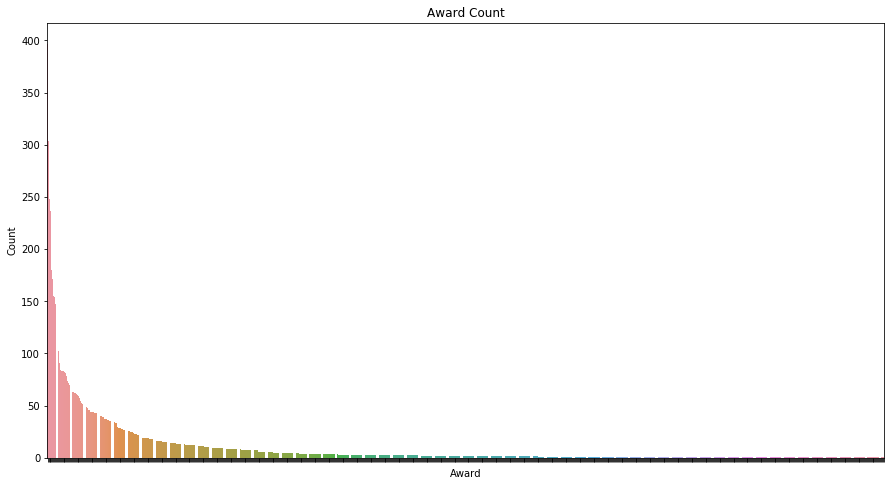

In [114]:
plt.figure(figsize=(15,8))
g=sns.barplot(w_awards.index,w_awards.values)
g.set(xticklabels=[])
plt.xlabel('Award')
plt.ylabel('Count')
plt.title('Award Count')
plt.show()

In [122]:
w_awards.head(10)

Golden Globe                  397
Star on the Walk of Fame      304
NBR Award                     248
Oscar                         237
Primetime Emmy                180
BAFTA Film Award              171
Lifetime Achievement Award    155
Actor                         154
NYFCC Award                   147
People's Choice Award         136
Name: category, dtype: int64

Some actors won the same award multiple times so we now count each prize only once per actor.

In [128]:
w_awards_once=df_actors_awards_oscars[df_actors_awards_oscars.w_n=='Winner'].groupby('nconst')['category'].unique().apply(pd.Series).stack().reset_index(drop=True).value_counts()

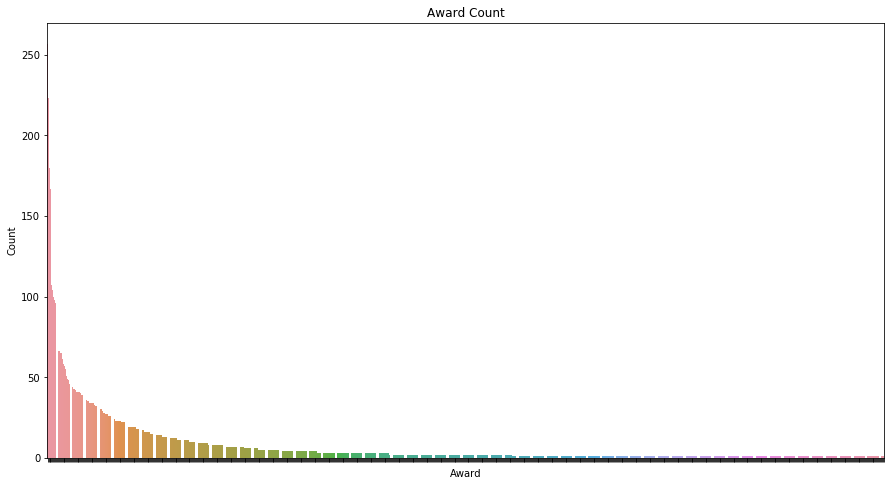

In [150]:
plt.figure(figsize=(15,8))
g=sns.barplot(w_awards_once.index,w_awards_once.values)
g.set(xticklabels=[])
plt.xlabel('Award')
plt.ylabel('Count')
plt.title('Award Count')
plt.show()

In [130]:
w_awards_once.head(10)

Star on the Walk of Fame      257
Golden Globe                  223
Oscar                         180
NBR Award                     167
BAFTA Film Award              107
Primetime Emmy                104
NYFCC Award                   100
Lifetime Achievement Award     98
KCFCC Award                    96
Actor                          89
dtype: int64

Now lets check wether there is a difference in the awards won by actors playing in oscar winning movies and the once not playing in oscar winning movies.

In [131]:
df_actors_awards_no_oscars=df_actors_awards[~df_actors_awards.nconst.isin(oscar_stars)]

In [134]:
w_awards_no_oscar=df_actors_awards_no_oscars[df_actors_awards_no_oscars.w_n=='Winner']['category'].value_counts()

In [135]:
w_awards_no_oscar.head(10)

Grammy                      1439
Star on the Walk of Fame    1348
Best Actor                  1239
Audience Award              1216
Festival Prize              1207
Primetime Emmy              1158
Jury Award                  1132
Best Actress                1105
Festival Award              1039
Special Award                934
Name: category, dtype: int64

In [136]:
w_awards_no_oscar_once=df_actors_awards_no_oscars[df_actors_awards_no_oscars.w_n=='Winner'].groupby('nconst')['category'].unique().apply(pd.Series).stack().reset_index(drop=True).value_counts()

In [137]:
w_awards_no_oscar_once.head(10)

Star on the Walk of Fame    1200
Best Actor                   996
Festival Prize               916
Best Actress                 884
Jury Award                   875
Audience Award               793
Festival Award               756
Special Award                756
Golden Globe                 658
Jury Prize                   645
dtype: int64

In [145]:
df_top10_awards=pd.DataFrame(data=[w_awards_once.head(10).index,w_awards_no_oscar_once.head(10).index]).T
df_top10_awards.columns=['Actors in Oscar movies','Actors not in Oscar movies']
df_top10_awards

Actors in Oscar movies Actors not in Oscar movies
0    Star on the Walk of Fame   Star on the Walk of Fame
1                Golden Globe                 Best Actor
2                       Oscar             Festival Prize
3                   NBR Award               Best Actress
4            BAFTA Film Award                 Jury Award
5              Primetime Emmy             Audience Award
6                 NYFCC Award             Festival Award
7  Lifetime Achievement Award              Special Award
8                 KCFCC Award               Golden Globe
9                       Actor                 Jury Prize

We can see that there is a difference in the awards won of actors playing in at least one oscar winning movie and actors that did not act in a oscar winning movie so far. Hence it could make sense to choose the actors to play in a movie according to the awards they won.

Now lets see if there are actors that can guarantee an oscar win.

In [168]:
#first filter all the movies that have an actor in them that played in an oscar winning movie
movies_data_exploded=movies_data.explode('stars')
movies_oscar_actors=movies_data_exploded[movies_data_exploded.stars.isin(oscar_stars)]

In [176]:
movies_oscar_actors.head(1)

tconst      stars  oscarWins  nominations  wins releaseDate  \
15  tt0014760  nm0723658          0            0     0  1924-07-06   

   releaseCountry plotKeywords budget worldwideGross  ...    originalTitle  \
15            USA           []   None           None  ...  Captain January   

   startYear runtimeMinutes   genres  averageRating numVotes releaseMonth  \
15    1924.0             64  [Drama]            6.9    194.0          7.0   

    releaseYear  budget_in_dollar  worldwideGross_in_dollar  
15       1924.0             False                     False  

[1 rows x 23 columns]

In [197]:
s1=movies_oscar_actors.stars[movies_oscar_actors.oscarWins>0].value_counts()
s2=movies_oscar_actors.stars.value_counts()
df_s1_s2=pd.concat([s1, s2],sort=False, axis=1)
df_s1_s2.columns=['Oscar_movies','Total_movies']
df_s1_s2['Win_percentage']=df_s1_s2.Oscar_movies/df_s1_s2.Total_movies
df_s1_s2.sort_values('Win_percentage',ascending=False).head(20)

Oscar_movies  Total_movies  Win_percentage
nm0095029             1             1             1.0
nm9948845             1             1             1.0
nm0021655             1             1             1.0
nm0924009             1             1             1.0
nm0641314             1             1             1.0
nm8611957             1             1             1.0
nm0349776             1             1             1.0
nm0156187             1             1             1.0
nm0633661             1             1             1.0
nm0576345             1             1             1.0
nm0591034             1             1             1.0
nm0001343             1             1             1.0
nm0658336             1             1             1.0
nm0186408             1             1             1.0
nm0488267             1             1             1.0
nm0488306             1             1             1.0
nm0222627             1             1             1.0
nm0905697             1             2             0.5
nm5218990             1             2             0.5
nm0942787             1             2             0.5

In [222]:
df_s1_s2.sort_values('Oscar_movies',ascending=False).head(20)

KeyError: 'Oscar_movies'

### Which Actors are in award winning movies and which awards did they win

In [203]:
df_awards_movies=movies_data[movies_data.wins>0]

awards_stars=df_awards_movies.stars.apply(pd.Series).stack().reset_index(drop=True)


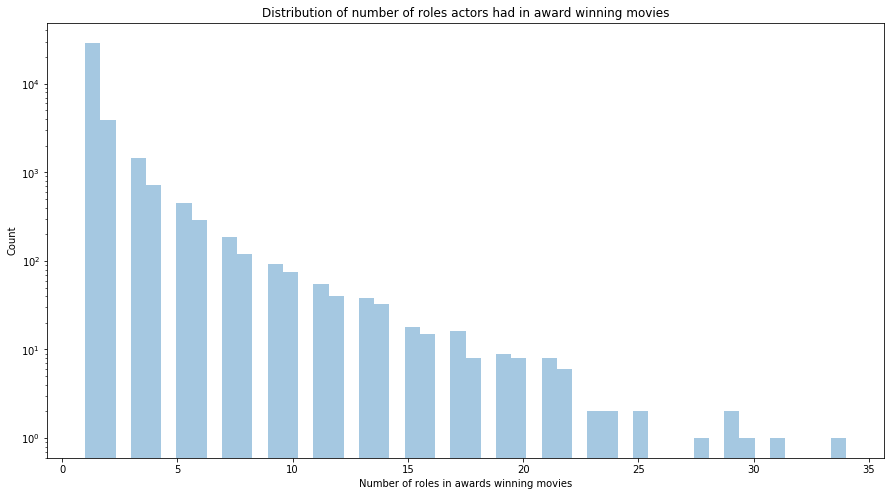

In [205]:
plt.figure(figsize=(15,8))
ax=sns.distplot(awards_stars.value_counts(),kde=None)
ax.set_yscale('log')
plt.xlabel('Number of roles in awards winning movies')
plt.ylabel('Count')
plt.title('Distribution of number of roles actors had in award winning movies')
plt.show()

In [206]:
df_awards_stars=awards_stars.to_frame('nconst')

df_actors_awards_awards=df_actors_awards[df_actors_awards.nconst.isin(awards_stars)]

df_actors_awards_awards.head()

nconst  year       category      w_n  \
0  nm0309470  2005          David  Nominee   
1  nm0309470  1968   Golden Plate   Winner   
2  nm0309470  2005    Golden Ciak   Winner   
3  nm0309470  1967   Golden Globe   Winner   
4  nm0309470  1968  Golden Goblet   Winner   

                                         description               movie  \
0  Best Supporting Actress (Migliore Attrice non ...         Cuore sacro   
1                                                             Grazie zia   
2  Best Supporting Actress (Migliore Attrice Non ...         Cuore sacro   
3                    Best Actress (Migliore Attrice)  Svegliati e uccidi   
4                    Best Actress (Migliore Attrice)          Grazie zia   

      tconst  Important  
0  tt0429898      False  
1  tt0063033      False  
2  tt0429898      False  
3  tt0061049       True  
4  tt0063033      False

In [209]:
w_awards_awards=df_actors_awards_awards[df_actors_awards_awards.w_n=='Winner']['category'].value_counts()

In [213]:
w_awards_awards_once=df_actors_awards_awards[df_actors_awards_awards.w_n=='Winner'].groupby('nconst')['category'].unique().apply(pd.Series).stack().reset_index(drop=True).value_counts()

In [214]:
df_actors_awards_no_awards=df_actors_awards[~df_actors_awards.nconst.isin(awards_stars)]

w_awards_no_awards=df_actors_awards_no_awards[df_actors_awards_no_awards.w_n=='Winner']['category'].value_counts()

w_awards_no_awards_once=df_actors_awards_no_awards[df_actors_awards_no_awards.w_n=='Winner'].groupby('nconst')['category'].unique().apply(pd.Series).stack().reset_index(drop=True).value_counts()

In [215]:
w_awards_awards_once.head(10)

Best Actor                  911
Best Actress                755
Star on the Walk of Fame    722
Golden Globe                705
Festival Prize              670
Jury Award                  597
Special Award               561
Audience Award              541
Primetime Emmy              480
NBR Award                   462
dtype: int64

In [216]:
df_top10_awards_awards=pd.DataFrame(data=[w_awards_awards_once.head(10).index,w_awards_no_awards_once.head(10).index]).T
df_top10_awards_awards.columns=['Actors in award movies','Actors not in awards movies']
df_top10_awards_awards

Actors in award movies      Actors not in awards movies
0                Best Actor         Star on the Walk of Fame
1              Best Actress  People's Artist of the Republic
2  Star on the Walk of Fame                   Festival Award
3              Golden Globe                       Jury Award
4            Festival Prize                   Audience Award
5                Jury Award                   Festival Prize
6             Special Award                    Special Award
7            Audience Award                           Grammy
8            Primetime Emmy                   Primetime Emmy
9                 NBR Award                       Jury Prize

In [218]:
#first filter all the movies that have an actor in them that played in an award winning movie
movies_award_actors=movies_data_exploded[movies_data_exploded.stars.isin(awards_stars)]

In [224]:
s1=movies_award_actors.stars[movies_award_actors.wins>0].value_counts()
s2=movies_award_actors.stars.value_counts()
df_s1_s2=pd.concat([s1, s2],sort=False, axis=1)
df_s1_s2.columns=['Award_movies','Total_movies']
df_s1_s2['Win_percentage']=df_s1_s2.Award_movies/df_s1_s2.Total_movies
df_s1_s2.sort_values('Win_percentage',ascending=False).head(20)

Award_movies  Total_movies  Win_percentage
nm0926259              1             1             1.0
nm1543019              1             1             1.0
nm7432551              1             1             1.0
nm8079967              1             1             1.0
nm8119329              1             1             1.0
nm0500739              1             1             1.0
nm1221054              1             1             1.0
nm0055435              1             1             1.0
nm1574424              1             1             1.0
nm10635665             1             1             1.0
nm4623906              1             1             1.0
nm0354641              1             1             1.0
nm0508527              1             1             1.0
nm0033294              1             1             1.0
nm0074058              1             1             1.0
nm0374403              1             1             1.0
nm10235237             1             1             1.0
nm10592419             1             1             1.0
nm0320980              1             1             1.0
nm0798534              1             1             1.0

In [230]:
df_s1_s2.sort_values('Award_movies',ascending=False).head(20)

Award_movies  Total_movies  Win_percentage
nm0000052            34           109        0.311927
nm0000134            31            63        0.492063
nm0000367            30           103        0.291262
nm0704719            29           109        0.266055
nm0764298            29            88        0.329545
nm0209649            28            65        0.430769
nm0042124            25            65        0.384615
nm0273178            25           110        0.227273
nm0000164            24            51        0.470588
nm0000158            24            43        0.558140
nm0527002            23            51        0.450980
nm0586733            23            91        0.252747
nm0000658            22            33        0.666667
nm0000154            22            41        0.536585
nm0451321            22            41        0.536585
nm0000821            22           138        0.159420
nm0634159            22            85        0.258824
nm0000172            22            67        0.328358
nm0001376            21            68        0.308824
nm0352032            21           170        0.123529